In [1]:
import chess
import chess.engine
import random
import numpy as np


# this function will create our x (board)
def random_board(max_depth=200):
  board = chess.Board()
  depth = random.randrange(0, max_depth)

  for _ in range(depth):
    all_moves = list(board.legal_moves)
    random_move = random.choice(all_moves)
    board.push(random_move)
    if board.is_game_over():
      break

  return board


# this function will create our f(x) (score)
def stockfish(board, depth):
  engine = chess.engine.SimpleEngine.popen_uci("/home/dsc/Data_Science_Projects/Chess_Engine_TFM/engine/stockfish_15.1_linux_x64_bmi2/stockfish_15.1_x64_bmi2")
  result = engine.analyse(board, chess.engine.Limit(depth=depth))
  score = result['score'].white().score()
  return score

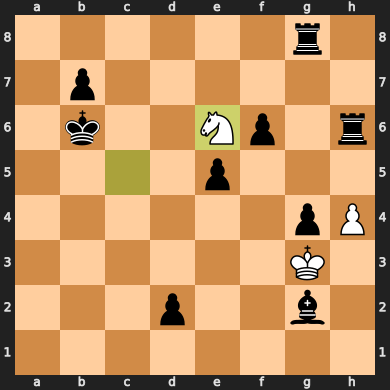

In [2]:
board = random_board()
board

In [3]:
print(stockfish(board, 10))

-3717


**The AI will learn how to give a accurate prediction of *f(x)* when we present a *x* never seen before.**

*board -> score*

# Creating the dataset

Now we need to convert the board representation to something meaningful.

A 3d matrix of sizes **14 x 8 x 8**

In [4]:
squares_index = {
  'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7
}


# example: h3 -> 17
def square_to_index(square):
  letter = chess.square_name(square)
  return 8 - int(letter[1]), squares_index[letter[0]]


def split_dims(board):
  # this is the 3d matrix
  board3d = np.zeros((14, 8, 8), dtype=np.int8)

  # here we add the pieces's view on the matrix
  for piece in chess.PIECE_TYPES:
    for square in board.pieces(piece, chess.WHITE):
      idx = np.unravel_index(square, (8, 8))
      board3d[piece - 1][7 - idx[0]][idx[1]] = 1
    for square in board.pieces(piece, chess.BLACK):
      idx = np.unravel_index(square, (8, 8))
      board3d[piece + 5][7 - idx[0]][idx[1]] = 1

  # add attacks and valid moves too
  # so the network knows what is being attacked
  aux = board.turn
  board.turn = chess.WHITE
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[12][i][j] = 1
  board.turn = chess.BLACK
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[13][i][j] = 1
  board.turn = aux

  return board3d

In [5]:
split_dims(board)

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

Now, all we have to do is call **random_board()** to create random boards, **stockfish()** to get a score for how good each board is for white.

Then we convert each board to a 3d matrix using **split_dims()**, now creating the dataset is easy!

# TensorFlow!

In [6]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers


def build_model(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
  x = board3d
  for _ in range(conv_depth):
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', activation='relu', data_format='channels_first')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(64, 'relu')(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

2023-01-07 10:21:44.777415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-07 10:21:45.396236: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-07 10:21:45.396263: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-07 10:21:47.018428: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-0

2023-01-07 10:21:49.126883: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-07 10:21:49.126927: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-07 10:21:49.126953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kschool-vm): /proc/driver/nvidia/version does not exist
2023-01-07 10:21:49.128014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


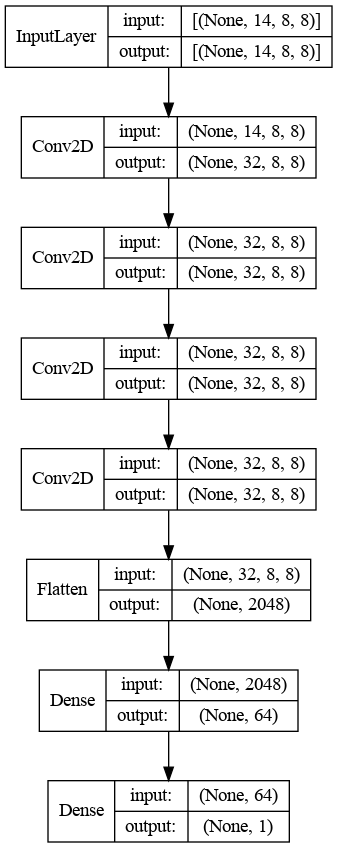

In [7]:
model = build_model(32, 4)
utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

Skip connections (residual network) will likely improve the model for deeper connections. If you want to test the residual model, check the code below.

In [8]:
def build_model_residual(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
  x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', data_format='channels_first')(board3d)
  for _ in range(conv_depth):
    previous = x
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', data_format='channels_first')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', data_format='channels_first')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, previous])
    x = layers.Activation('relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

# It's training time!

In [9]:
import tensorflow.keras.callbacks as callbacks


def get_dataset():
	container = np.load('/home/dsc/Data_Science_Projects/Chess_Engine_TFM/data/random_data/dataset.npz')
	b, v = container['b'], container['v']
	v = np.asarray(v / abs(v).max() / 2 + 0.5, dtype=np.float32) # normalization (0 - 1)
	return b, v


x_train, y_train = get_dataset()
print(x_train.shape)
print(y_train.shape)

(1500000, 14, 8, 8)
(1500000,)


In [12]:

model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error')
model.summary()
model.fit(x_train, y_train,
          batch_size=1048,
          epochs=10,
          verbose=1,
          validation_split=0.1,
          callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
                     callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4)])

model.save('model.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d (Conv2D)             (None, 32, 8, 8)          4064      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 8, 8)          9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 8, 8)          9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 8, 8)          9248      
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136

2023-01-07 10:22:28.534172: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2419200000 exceeds 10% of free system memory.


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/model/conv2d_3/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "/home/dsc/anaconda3/envs/chess/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/dsc/anaconda3/envs/chess/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/dsc/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/dsc/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/home/dsc/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/dsc/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/dsc/anaconda3/envs/chess/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/dsc/anaconda3/envs/chess/lib/python3.10/asyncio/base_events.py", line 1899, in _run_once
      handle._run()
    File "/home/dsc/anaconda3/envs/chess/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/dsc/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/dsc/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/dsc/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/dsc/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/dsc/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/dsc/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 530, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/dsc/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/home/dsc/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/home/dsc/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/dsc/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/dsc/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/dsc/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_4383/2225825187.py", line 3, in <module>
      model.fit(x_train, y_train,
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 526, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 259, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/model/conv2d_3/Conv2D/Conv2DBackpropInput'
Conv2DCustomBackpropInputOp only supports NHWC.
	 [[{{node gradient_tape/model/conv2d_3/Conv2D/Conv2DBackpropInput}}]] [Op:__inference_train_function_4601]

# Playing with the AI

In [11]:
# used for the minimax algorithm
def minimax_eval(board):
  board3d = split_dims(board)
  board3d = np.expand_dims(board3d, 0)
  return model.predict(board3d)[0][0]


def minimax(board, depth, alpha, beta, maximizing_player):
  if depth == 0 or board.is_game_over():
    return minimax_eval(board)
  
  if maximizing_player:
    max_eval = -np.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, False)
      board.pop()
      max_eval = max(max_eval, eval)
      alpha = max(alpha, eval)
      if beta <= alpha:
        break
    return max_eval
  else:
    min_eval = np.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, True)
      board.pop()
      min_eval = min(min_eval, eval)
      beta = min(beta, eval)
      if beta <= alpha:
        break
    return min_eval


# this is the actual function that gets the move from the neural network
def get_ai_move(board, depth):
  max_move = None
  max_eval = -np.inf

  for move in board.legal_moves:
    board.push(move)
    eval = minimax(board, depth - 1, -np.inf, np.inf, False)
    board.pop()
    if eval > max_eval:
      max_eval = eval
      max_move = move
  
  return max_move

In [12]:
board = chess.Board()

with chess.engine.SimpleEngine.popen_uci("/home/dsc/Data_Science_Projects/Chess_Engine_TFM/engine/stockfish_15.1_linux_x64_bmi2/stockfish_15.1_x64_bmi2") as engine:
  while True:
    move = get_ai_move(board, 1)
    board.push(move)
    print(f'\n{board}')
    if board.is_game_over():
      break

    move = engine.analyse(board, chess.engine.Limit(time=1), info=chess.engine.INFO_PV)['pv'][0]
    board.push(move)
    print(f'\n{board}')
    if board.is_game_over():
      break

UnimplementedError: Graph execution error:

Detected at node 'model/conv2d/Conv2D' defined at (most recent call last):
    File "/home/dsc/anaconda3/envs/chess/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/dsc/anaconda3/envs/chess/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/dsc/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/dsc/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/home/dsc/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/dsc/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/dsc/anaconda3/envs/chess/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/dsc/anaconda3/envs/chess/lib/python3.10/asyncio/base_events.py", line 1899, in _run_once
      handle._run()
    File "/home/dsc/anaconda3/envs/chess/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/dsc/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/dsc/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/dsc/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/dsc/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/dsc/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/dsc/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 530, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/dsc/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/home/dsc/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/home/dsc/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/dsc/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/dsc/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/dsc/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_18615/267158644.py", line 5, in <module>
      move = get_ai_move(board, 1)
    File "/tmp/ipykernel_18615/1685798917.py", line 43, in get_ai_move
      eval = minimax(board, depth - 1, -np.inf, np.inf, False)
    File "/tmp/ipykernel_18615/1685798917.py", line 10, in minimax
      return minimax_eval(board)
    File "/tmp/ipykernel_18615/1685798917.py", line 5, in minimax_eval
      return model.predict(board3d)[0][0]
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2350, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2137, in predict_function
      return step_function(self, iterator)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2123, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in run_step
      outputs = model.predict_step(data)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/engine/training.py", line 2079, in predict_step
      return self(x, training=False)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/dsc/.local/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'model/conv2d/Conv2D'
The Conv2D op currently only supports the NHWC tensor format on the CPU. The op was given the format: NCHW
	 [[{{node model/conv2d/Conv2D}}]] [Op:__inference_predict_function_1767]

In [ ]:
!cp "/content/drive/My Drive/dataset.zip" /content/dataset.zip
!unzip dataset.zip
!rm dataset.zip
!chmod +x stockfish

In [ ]:
import random
random.seed(37)